In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2

import random
import math
import networkx as nx

import boto3
from PIL import Image

import requests
import json

from tqdm import tqdm
getattr(tqdm, '_instances', {}).clear()  # ⬅ add this line

%matplotlib inline

plt.style.use('ggplot')

pd.set_option('display.max_columns', 50)

In [2]:
import matplotlib.image as mpimg # show images
from io import BytesIO # reading bytes

import pickle # save images
import time # get time stamp of models trained
import shap

## Import Images

In [3]:
# grab and resize image from and to s3 bucket

bucket = 'cwbirdsimages'
img_dir = 'new_images' # folder containing all other folders of images
folders = ['ducks', 'finches', 'hawks']

def resize_images_array(img_dir, folders, bucket):
    # arrays of image pixels
    img_arrays = []
    labels = []
    
    # loop through the dataframe that is linked to its label so that all images are in the same order
    for folder in tqdm(folders):
        s3 = boto3.client('s3')
        enter_folder = s3.list_objects_v2(Bucket=bucket, Prefix=f'{img_dir}/{folder}')
        for i in enter_folder['Contents'][2:]:
            try:
                filepath = i['Key']
                obj = s3.get_object(Bucket=bucket, Key=f'{filepath}')
                img_bytes = BytesIO(obj['Body'].read())
                open_img = Image.open(img_bytes)
                arr = np.array(open_img.resize((200,200))) # resize to 200,200. possible to play around with better or worse resolution
                img_arrays.append(arr)
                labels.append(folder)
            except:
                print(filepath) # get file_path of ones that fail to load
                continue

    return np.array(img_arrays), np.array(labels)

In [ ]:
# testing = []

# s3 = boto3.client('s3')
# enter_folder = s3.list_objects_v2(Bucket='cwbirdsimages', Prefix='new_images/finches')
# for i in enter_folder['Contents'][2:5]:
#     filepath = i['Key']
#     try:
#         obj = s3.get_object(Bucket='cwbirdsimages', Key=f'{filepath}')
#         print('obj: ', obj)
#         img_bytes = BytesIO(obj['Body'].read())
#         open_img = Image.open(img_bytes)
#         print(open_img)
#         arr = np.array(open_img.resize((200,200))) # resize to 200,200. possible to play around with better or worse resolution
#         print(arr)
#         testing.append(arr)
#         print(testing)
#     except:
#         print('error', testing)
#         continue

In [4]:
X, y = resize_images_array(img_dir, folders, bucket)

100%|██████████| 3/3 [03:57<00:00, 79.02s/it]


In [7]:
print('X shape: ', X.shape)
print('y_shape: ', y.shape)

X shape:  (2986, 200, 200, 3)
y_shape:  (2986,)


### Look at single image

In [12]:
s3 = boto3.client('s3')

obj = s3.get_object(Bucket=bucket, Key=f'new_images/ducks/0296/069519c379574fb285d7bb920443ea89.jpg')
img_bytes = BytesIO(obj['Body'].read())
duck1 = Image.open(img_bytes)

In [13]:
obj = s3.get_object(Bucket=bucket, Key=f'new_images/hawks/0495/03126240f9974b259e1c0bc142af7edc.jpg')
img_bytes = BytesIO(obj['Body'].read())
hawk1 = Image.open(img_bytes)

In [14]:
obj = s3.get_object(Bucket=bucket, Key=f'new_images/finches/1001/0edd165e46054dd388dcb9dae4e58f87.jpg')
img_bytes = BytesIO(obj['Body'].read())
finch1 = Image.open(img_bytes)

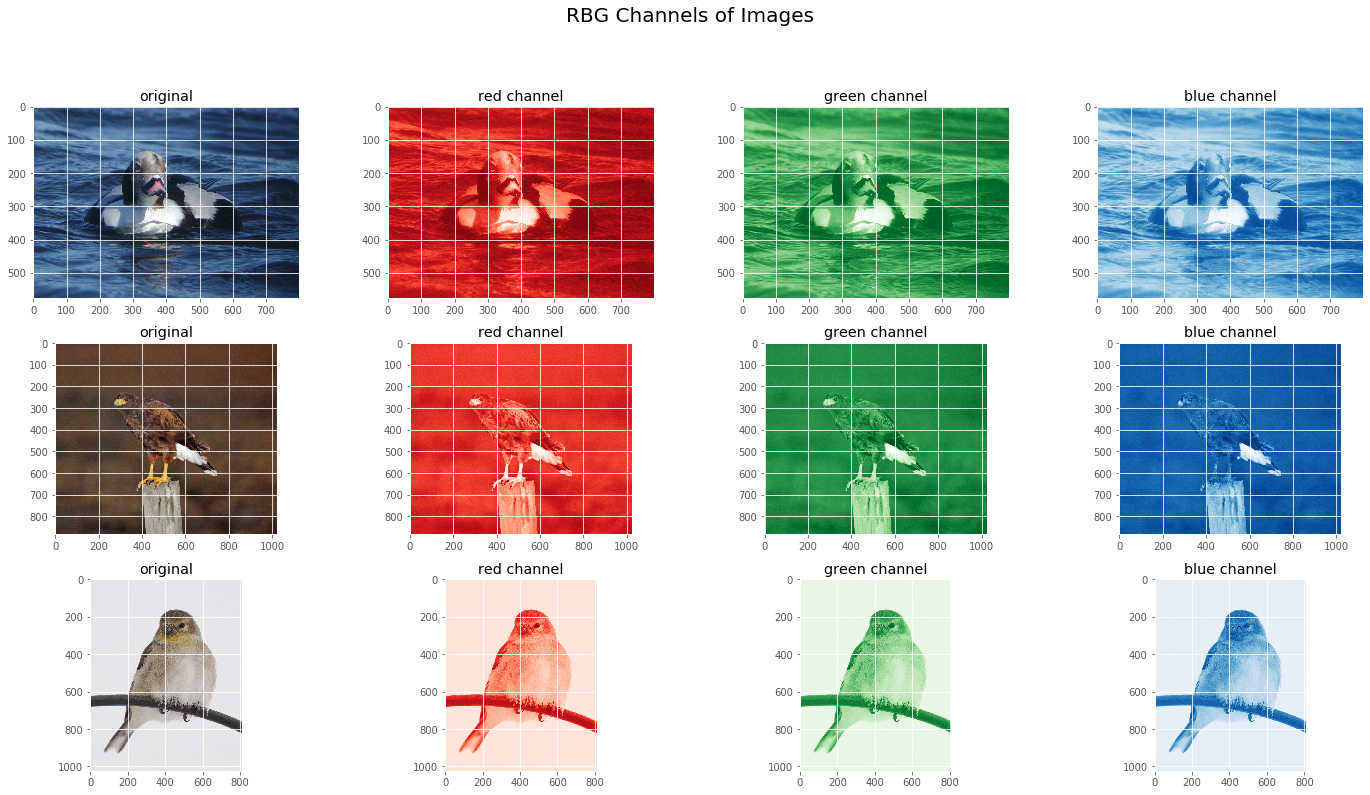

In [49]:
# By stacking these together into a 3-tensor, we can represent a color image as a single object.

fig, axes = plt.subplots(3, 4, figsize=(20,10));

fig.suptitle('RBG Channels of Images', y=1.1, fontsize=20)

axes[0][0].imshow(duck1);
axes[0][0].set_title('original')
for ax, channel, name in zip(axes[0][1:], duck1.split(), ['red channel', 'green channel', 'blue channel']):
    ax.imshow(channel, cmap=f'{name.split()[0].capitalize()}s_r');
    ax.set_title(name)
    
axes[1][0].imshow(hawk1);
axes[1][0].set_title('original')
for ax, channel, name in zip(axes[1][1:], hawk1.split(), ['red channel', 'green channel', 'blue channel']):
    ax.imshow(channel, cmap=f'{name.split()[0].capitalize()}s_r');
    ax.set_title(name)
    
axes[2][0].imshow(finch1);
axes[2][0].set_title('original')
for ax, channel, name in zip(axes[2][1:], finch1.split(), ['red channel', 'green channel', 'blue channel']):
    ax.imshow(channel, cmap=f'{name.split()[0].capitalize()}s_r');
    ax.set_title(name)

plt.tight_layout()
plt.savefig('graphs/dhf_RBGplot.png')

### Normalize Feature Arrays

In [50]:
# normalize the RBG values
X = X/255.0

### Label and Features

In [58]:
label = y.copy()

In [60]:
label

array(['ducks', 'ducks', 'ducks', ..., 'hawks', 'hawks', 'hawks'],
      dtype='<U7')

In [66]:
y = np.array(label.reshape(-1,1) == folders).astype(float)

In [68]:
y[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [69]:
print('label shape: ', y.shape)
print('features shape: ', X.shape)

label shape:  (2986, 3)
features shape:  (2986, 200, 200, 3)


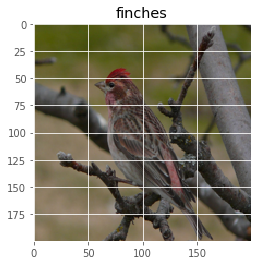

In [88]:
# check to make sure the bird images and labels are aligned
# this is indeed a semipalmated sandpiper

# fig, ax = 

plt.title(f'{folders[y_train[2].argmax()]}')
plt.imshow(X_train[2]);

# Model Time

### Work Flow

1. X, and y defined
- make sure they are arrays!!

2. normalize X values by dividing by 255
3. check images
4. train test split
5. make model Sequential()
6. add input layer
7. add multiple hidden layers
8. ADD FLATTEN LAYER, MUST BE BEFORE OUTPUT
9. add dense layer, which are fully connected layers
10. add output dense layer, will be the amount of labels there are
11. model.compile(loss = 'sparse_categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
12. model.fit(xtrain, ytrain, epochs) also has validation_split (out of sample) do about 0.1, batchsize: how many at a time, more data requires bigger (20-200 range)
13. model.evaluate(xtest,ytest) returns val loss and val accuracy  

14. model.save('name') saves the model
- to load: new_model = tf.keras.models.load_model('name')

### Import Libraries

In [116]:
# keras and tensorflow downloads
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization # CNN
from tensorflow.keras.callbacks import TensorBoard # graphical visual of loss and accuracy over the epochs of train and test set
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import mlxtend

import datetime

tf.__version__

'2.2.0'

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

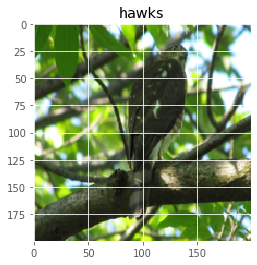

In [216]:
plt.title(f'{folders[y_train[55].argmax()]}')
plt.imshow(X_train[55]);

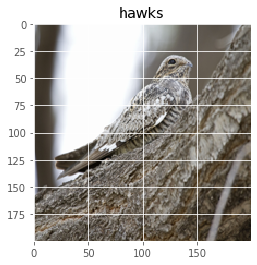

In [217]:
num = 10

plt.title(f'{folders[y_train[num].argmax()]}')
plt.imshow(X_train[num]);

In [218]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (2388, 200, 200, 3)
X_test shape:  (598, 200, 200, 3)
y_train shape:  (2388, 3)
y_test shape:  (598, 3)


## CNN: Convolutional Neural Network Modelx 1

In [219]:
# Create model
modelx1 = Sequential()

# Convolution Layer
modelx1.add(Conv2D(32, (3,3), activation='relu', input_shape=X_train[0].shape)) # scans with a (3,3) grid
modelx1.add(BatchNormalization())
modelx1.add(MaxPool2D(2,2)) # grid to pool together the first grid
modelx1.add(Dropout(0.3))

modelx1.add(Conv2D(64, (3,3), activation='relu')) # scans with a (3,3) grid
modelx1.add(BatchNormalization())
modelx1.add(MaxPool2D(2,2)) # grid to pool together the first grid
modelx1.add(Dropout(0.3))

modelx1.add(Conv2D(128, (3,3), activation='relu')) # scans with a (3,3) grid
modelx1.add(BatchNormalization())
modelx1.add(MaxPool2D(2,2)) # grid to pool together the first grid
modelx1.add(Dropout(0.4))

# Must Flatten before entering Dense layers
modelx1.add(Flatten())

modelx1.add(Dense(128, activation='relu'))
modelx1.add(BatchNormalization())
modelx1.add(Dropout(0.4))

# modelx1.add(Dense(128, activation='relu'))
# modelx1.add(BatchNormalization())
# modelx1.add(Dropout(0.4))

modelx1.add(Dense(y_train.shape[1], activation='softmax')) # have to have same amount as y_train.shape[1]

In [221]:
print('Modelx 3: CNN-3Conv-1Dense')
print(f'Number of Training Images: {X_train.shape[0]}/{X_train.shape[0] + X_test.shape[0]}')
modelx1.summary()

Modelx 3: CNN-3Conv-1Dense
Number of Training Images: 2388/2986
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 198, 198, 32)      128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 97, 97, 64)        18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 97, 97, 64)        256       
________________________________________________________

In [222]:
modelx1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [223]:
log_dir = os.path.join("logs/fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [199]:
print('Modelx 3: CNN-3Conv-1Dense')
print(f'Number of Training Images: {X_train.shape[0]}/{X_train.shape[0] + X_test.shape[0]}')
historyx1 = modelx1.fit(X_train, y_train, batch_size = 100, epochs=10, validation_split=0.1, callbacks=[tensorboard_callback])

Modelx 2: CNN
Number of Training Images: 2388/2986
Epoch 1/10
22/22 [==============================] - 52s 2s/step - loss: 9.7685 - accuracy: 0.4681 - val_loss: 1.4369 - val_accuracy: 0.3808
Epoch 2/10
22/22 [==============================] - 51s 2s/step - loss: 2.6925 - accuracy: 0.6082 - val_loss: 1.9869 - val_accuracy: 0.3264
Epoch 3/10
22/22 [==============================] - 51s 2s/step - loss: 1.8206 - accuracy: 0.6975 - val_loss: 2.1934 - val_accuracy: 0.2803
Epoch 4/10
22/22 [==============================] - 51s 2s/step - loss: 1.9584 - accuracy: 0.7157 - val_loss: 3.0481 - val_accuracy: 0.3389
Epoch 5/10
22/22 [==============================] - 51s 2s/step - loss: 1.4270 - accuracy: 0.7483 - val_loss: 2.1131 - val_accuracy: 0.3933
Epoch 6/10
22/22 [==============================] - 51s 2s/step - loss: 1.1759 - accuracy: 0.7948 - val_loss: 1.5396 - val_accuracy: 0.3389
Epoch 7/10
22/22 [==============================] - 51s 2s/step - loss: 1.0537 - accuracy: 0.8046 - val_loss:

In [200]:
historyx1.history

{'loss': [9.76845645904541,
  2.6925084590911865,
  1.820591926574707,
  1.95840585231781,
  1.4270001649856567,
  1.1758784055709839,
  1.05374014377594,
  0.9097284078598022,
  0.6490054726600647,
  0.7576818466186523],
 'accuracy': [0.46812471747398376,
  0.6081898808479309,
  0.6975337266921997,
  0.7156817317008972,
  0.7482550144195557,
  0.7947883009910583,
  0.8045602440834045,
  0.8268962502479553,
  0.8622615337371826,
  0.8506281971931458],
 'val_loss': [1.4368637800216675,
  1.9869134426116943,
  2.1934432983398438,
  3.0480501651763916,
  2.1130800247192383,
  1.5395607948303223,
  3.408390760421753,
  1.0767241716384888,
  3.1684088706970215,
  6.118091583251953],
 'val_accuracy': [0.38075312972068787,
  0.3263598382472992,
  0.2803347408771515,
  0.33891212940216064,
  0.3933054506778717,
  0.33891212940216064,
  0.3891213536262512,
  0.5481171607971191,
  0.31380751729011536,
  0.3974895477294922]}

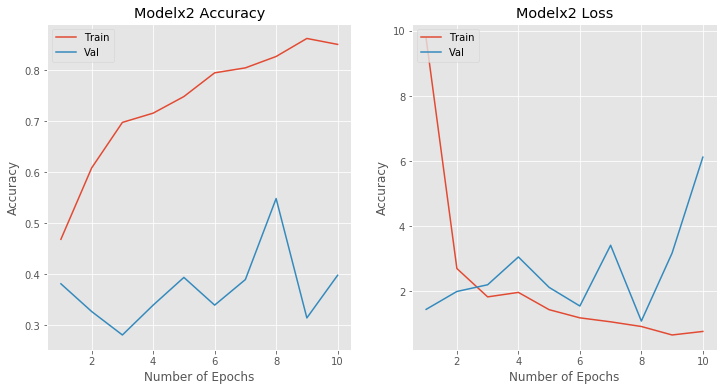

In [201]:
fig, axes = plt.subplots(1,2,figsize=(12,6))

epoch_range = range(1, 11)

axes[0].plot(epoch_range, historyx1.history['accuracy'])
axes[0].plot(epoch_range, historyx1.history['val_accuracy'])
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Number of Epochs')
axes[0].legend(['Train', 'Val'], loc='upper left')
axes[0].set_title('Modelx2 Accuracy')

axes[1].plot(epoch_range, historyx1.history['loss'])
axes[1].plot(epoch_range, historyx1.history['val_loss'])
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Number of Epochs')
axes[1].legend(['Train', 'Val'], loc='upper left')
axes[1].set_title('Modelx2 Loss')

plt.savefig('graphs/modelx2_acc_loss_overfit.png')

In [113]:
# %load_ext tensorboard

# %tensorboard --logdir='logs/'

In [202]:
pred1 = modelx1.predict(X_test)

In [203]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [204]:
y_true = y_test.copy()

In [205]:
y_true = np.array([i.argmax() for i in y_true]).reshape(-1,1)

In [206]:
y_predicted = (pred1 > 0.5).astype(float)

In [207]:
y_predicted = np.array([i.argmax() for i in y_predicted]).reshape(-1,1)

In [208]:
mat = confusion_matrix(y_true, y_predicted)

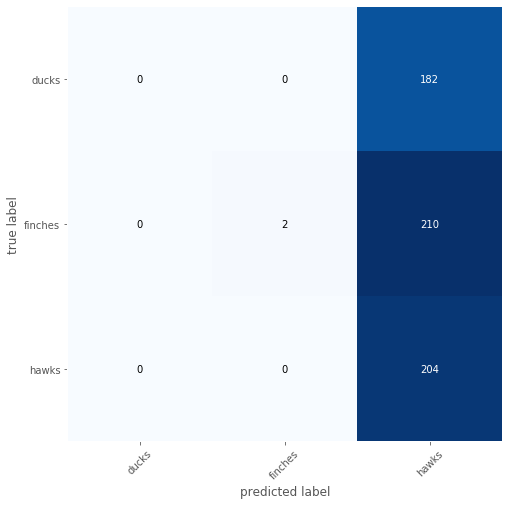

In [211]:
plot_confusion_matrix(conf_mat=mat, figsize=(8,8), class_names=folders);

plt.savefig('graphs/modelx_2_conf_mat.png')

In [212]:
modelx1.save('saved_models/modelx2-conv-3-dense-0.h5')
# keras.models.load_model

In [213]:
print('Modelx1 Loss and Accuracy: Overfit')
eval = modelx1.evaluate(X_test, y_test)

Modelx1 Loss and Accuracy: Overfit
19/19 [==============================] - 2s 107ms/step - loss: 6.9442 - accuracy: 0.3445
